In [2]:
# todo:
#fix tvf for different energy constants

#weigh chisq vs slope    
    #High chi square and low slope = good
    #low chi and sig slope = good
    #other combos = bad  
    
#epoint val

In [6]:
%matplotlib inline
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

EPOINT = 0 # need to fix this
np.seterr(invalid='ignore')
plt.rcParams.update({'font.size': 20})
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

In [56]:
def chiSq(data, fit, err_list):
    chisqSum = 0
    for y in range(len(data)):
        chisqSum += ((data[y] - fit[y]) / err_list[y])**2.0 
    return (chisqSum/np.size(data))

def getErr(data):
    err_dn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))
    err_up = (np.sqrt(data + 0.75) + 1.0)
    return err_up, err_dn

def fitDeg0(xaxis, yaxis, err_List):
    params, cov = np.polyfit(xaxis, yaxis, 0, cov=True, full =False)
    intercept = params
    degree0 = [intercept for i in xaxis]
    plt.plot(xaxis, degree0, 'green',  lw=2, label ='degree0')
    chisq = chiSq(yaxis, degree0, err_list)
    #plt.text(50, 6,'Slope = {:0.2e} +/- {:0.2e}'.format(slope,np.sqrt(cov[0][0])))
    #plt.text(50, 3.5,'Slope/Uncertainty = {:0.2f}'.format(np.abs(slope/np.sqrt(cov[0][0]))))
    #plt.text(50, 2,'Chi-Square = {:0.2f}'.format(chisq))
    return degree0

def fitDeg1(xaxis, yaxis, err_List):
    params, cov = np.polyfit(xaxis, yaxis, 1, cov=True, full =False)
    slope, intercept = params
    degree1 = [slope * i + intercept for i in xaxis]
    plt.plot(xaxis, degree1, 'blue',  lw=2, label = 'degree1')
    chisq = chiSq(yaxis, degree1, err_list)
    return degree1

def fitDeg2(xaxis, yaxis, err_List):
    params = np.polyfit(xaxis, yaxis, 2)
    poly = np.poly1d(params)
    xnew = np.linspace(xaxis[0], xaxis[-1], 50)
    fit4chi = poly(xaxis)
    degree2 = poly(xnew)
    plt.plot(xnew, degree2, 'red',  lw=2, label = 'degree2')
    chisq = chiSq(yaxis, fit4chi, err_list)
    return degree2


def fitSin(xaxis, yaxis):
    guess_freq = 200
    guess_amplitude = 3*np.std(yaxis)/(2**0.5)
    guess_phase = 0
    guess_offset = np.mean(yaxis)

    p0=[guess_freq, guess_amplitude,
        guess_phase, guess_offset]

    # create the function we want to fit
    def my_sin(x, freq, amplitude, phase, offset):
        vals =[]
        for z in range(len(x)): #using a loop here to get around a strange typeerror
            vals.append(np.sin(freq*x[z]+phase))
        return vals

    # now do the fit
    fit = curve_fit(my_sin, xaxis, yaxis, p0=p0)

    data_first_guess = my_sin(xaxis, *p0)

    # recreate the fitted curve using the optimized parameters
    data_fit = my_sin(xaxis, *fit[0])

    print()
    print(data_fit)
    print()
    plt.plot(xaxis, data_fit, label='after fitting')
    plt.plot(xaxis, data_first_guess, label='first guess')


D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



[0.47747738923252631, -0.435445913059407, -0.24096751444986292, 0.42270636649915511, -0.032873304987311822, 0.73211702009274171, 0.99996255631513742, -0.0089465911074636823, 0.099874702298791918, -0.27945826284112013, 0.81472980543059526, -0.95478803857593753, 0.53127745038186402, -0.22169445742754301]


[-0.98189133289247865, 0.20515420514812877, 0.26761478026775321, 0.40375265091768348, 0.091589992549332241, 0.79118669911521566, -0.2187538471186892, 0.28384261373577657, 0.26121482128751111, 0.090057550579325615, 0.054983342972509619, -0.53615764222763262, -0.36314842957328003, 0.78057540986517671, 0.56745782329049921, 0.66386495797295297]


[-0.55132461814037259, 0.45116653502430398, 0.89543405451723201, -0.19974656623940035, -0.62202174287301593, 0.26214358291865414, 0.29419813849677373, 0.88604331412097559, -0.70822028244258217, 0.034261632863035421, 0.97158221084047791, 0.32129755075241179, 0.56929079997424314, -0.64362539540133834]


[0.6249303537057872, -0.47027880720608745, -0

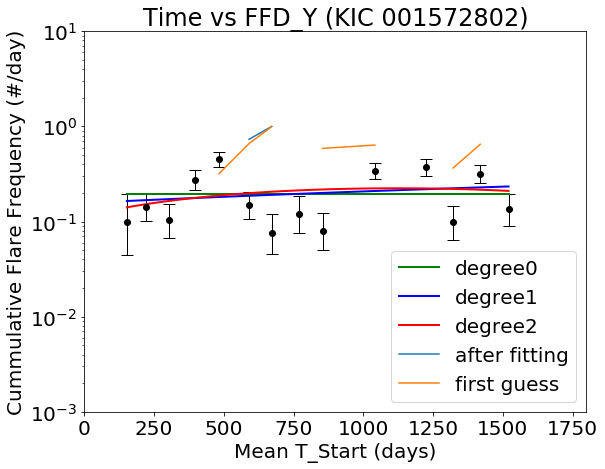

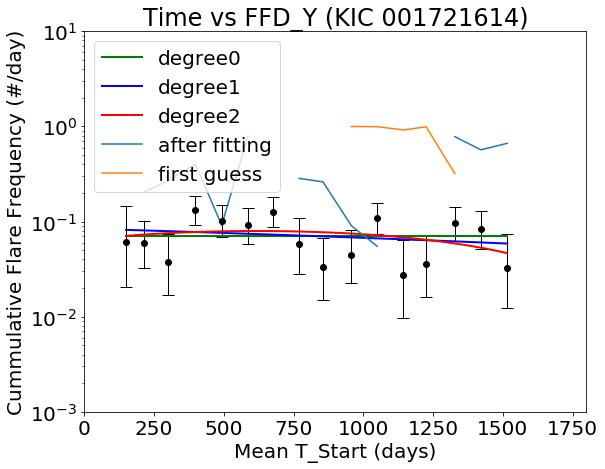

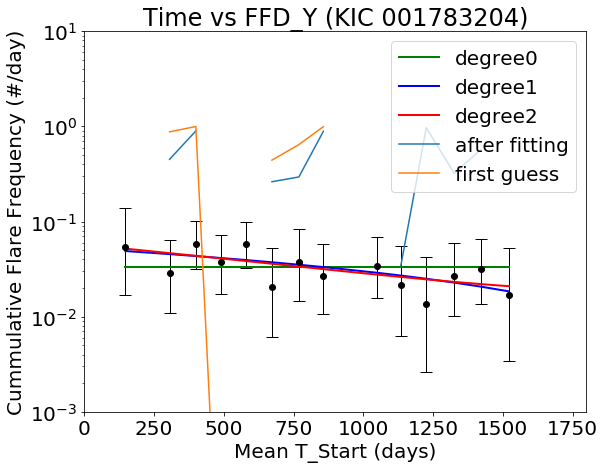

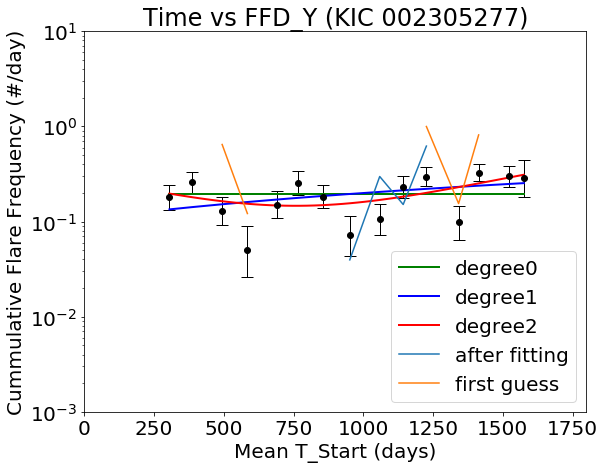

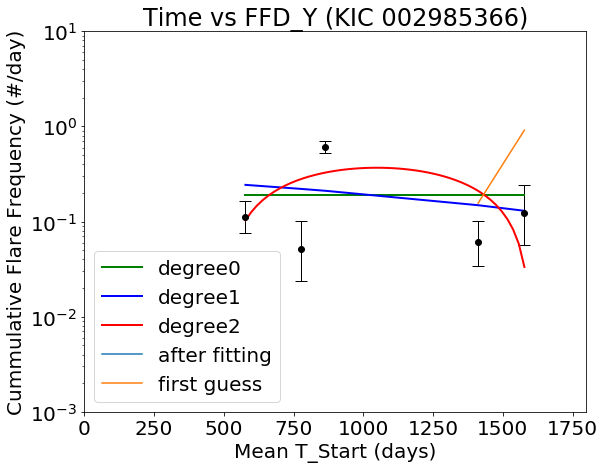

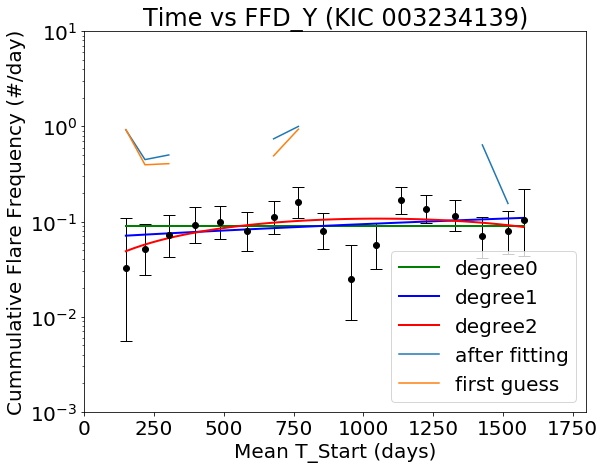

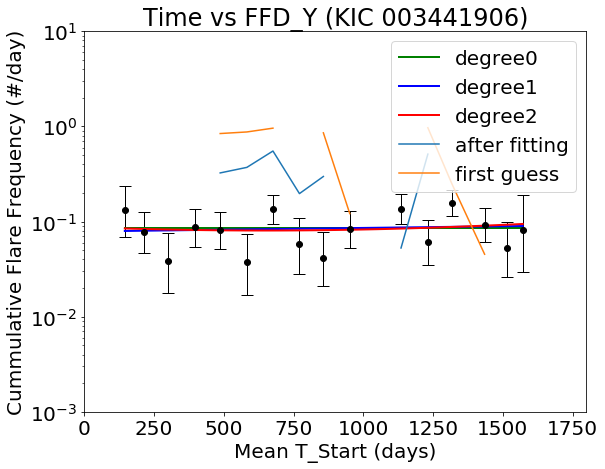

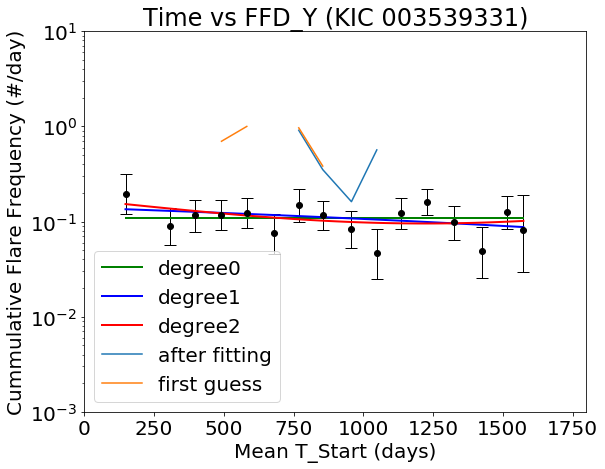

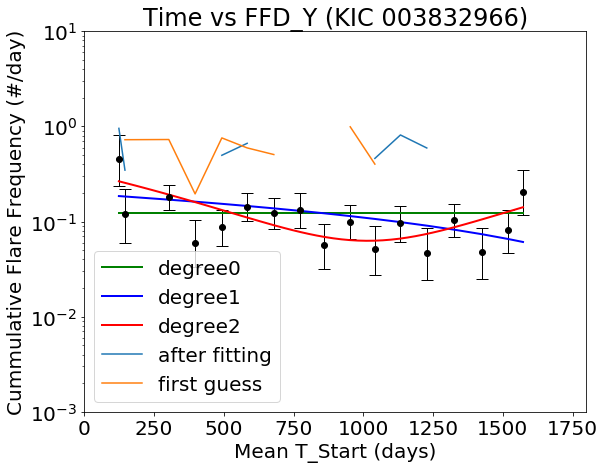

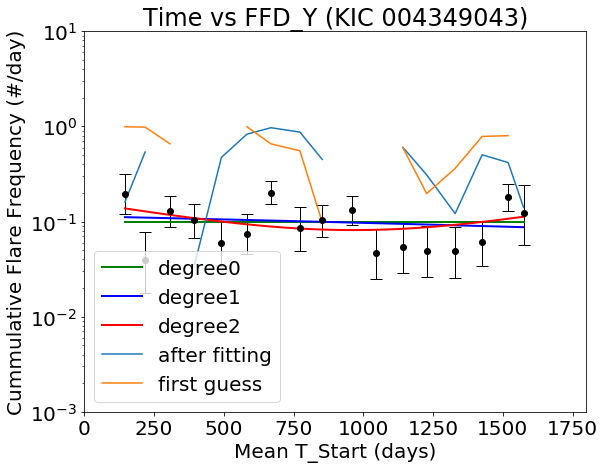

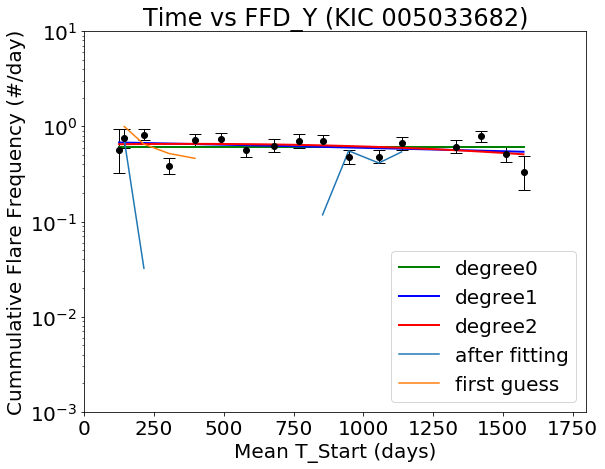

In [57]:
#Specify a fixed log-energy value. Plot the mean-time vs FFD_y values = plot time vs flare rate per day

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot
logEnergyConstant = 1.5 + EPOINT # the fixed energy value


for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("Time vs FFD_Y (KIC "+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Mean T_Start (days)")
    plt.yscale('log')
    plt.ylim([0.001,10])
    plt.xlim([0,1800])
    xaxis = []
    yaxis = []
    err_list = []
    
    for x in range(len(files)):

        #getting the total duration of each file
        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 

        
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array


        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        
        if(np.amax(ffd_xEnergy) >= logEnergyConstant >= np.amin(ffd_xEnergy)): #checking that the energy constant isn't out of bound,
                                                                               #otherwise, interpolate doesn't work

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            meanstart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file
     
    
            if any(ok68): #checking if ok68 contains at least one 'true'
                
                ffd_yForMeanstart = np.interp(logEnergyConstant, ffd_xEnergy[ok68][::-1], ffd_yFrequency[ok68][::-1])#interpolating the ffd_y

                xaxis.append(meanstart) #making lists so we can fit a line later
                yaxis.append(ffd_yForMeanstart)
                
                #dealing w/ error
                err_up, err_dn = getErr(ffd_yForMeanstart*toteDur)/toteDur
                err_list.append(err_up) #collecting errors, to be used in chi-square calc
                plt.errorbar(meanstart, ffd_yForMeanstart, yerr = [[err_dn], [err_up]], fmt='o', color= 'black',markersize=6, elinewidth=1,capsize=6)#plotting error
               
            
    degree0 = fitDeg0(xaxis, yaxis, err_list)
    degree1 = fitDeg1(xaxis, yaxis, err_list)
    degree2 = fitDeg2(xaxis, yaxis, err_list)
    fitSin(xaxis, yaxis)
    plt.legend()
    #plt.savefig('time-vs-ffd_y-plot/'+KIC+'_vs_time.png')

In [58]:
x = 1.543531231231
print(int(x))

1


In [ ]:
#plotting a reverse cummulative sum for a single KIC# number, hoping for a smooth change in frequency over time
#plotting all of the data, with data below the ED68i cutoff being the thinner lines

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log')

    for x in range(len(files)):

        #getting the total duration of each file
        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 
   
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array

        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
    
        plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68
        plt.plot(ffd_xEnergy, ffd_yFrequency, lw = 0.3, c = cmap(x/float(len(files)))) #plotting all data

        
        #plotting the error bars. Must use the total flare #, rather than frequency, to calc the error.
        err_dn =  []
        err_up = []
        
        for y in range (len(ffd_yFrequency)):
            
            toteFlare = toteDur*ffd_yFrequency[y]
            err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
            err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)
            
        plt.errorbar(ffd_xEnergy, ffd_yFrequency, yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .55)
        
    #plt.savefig('ffd_x-vs-ffd_y-whole-plot/'+KIC+'_whole_FFD.png')


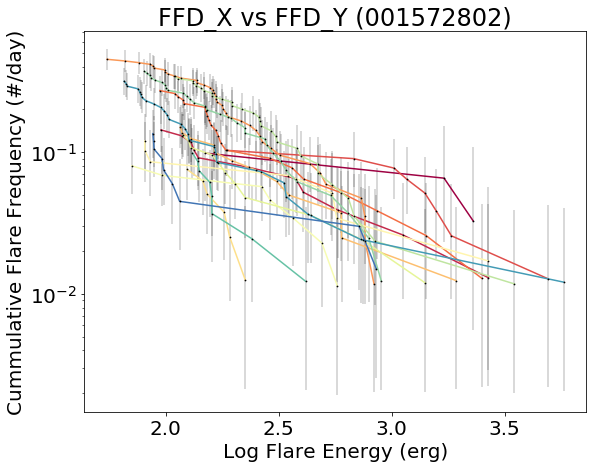

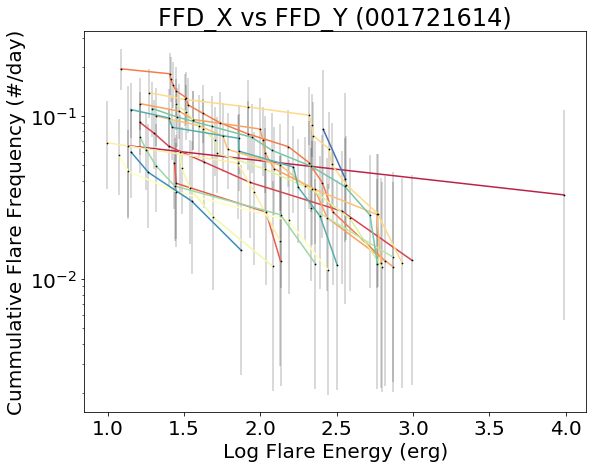

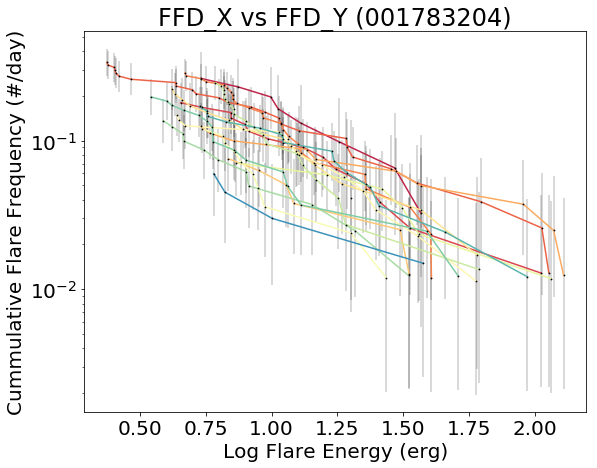

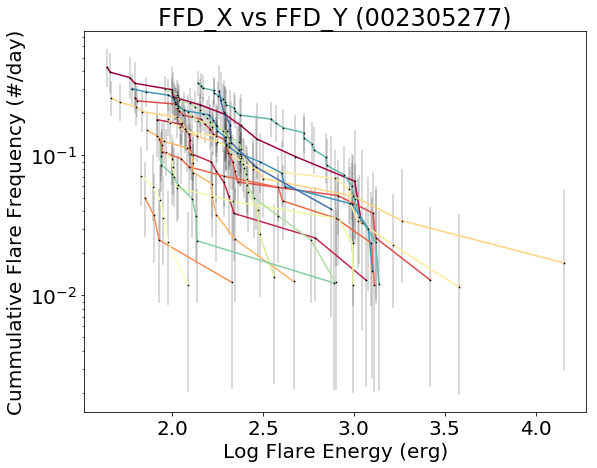

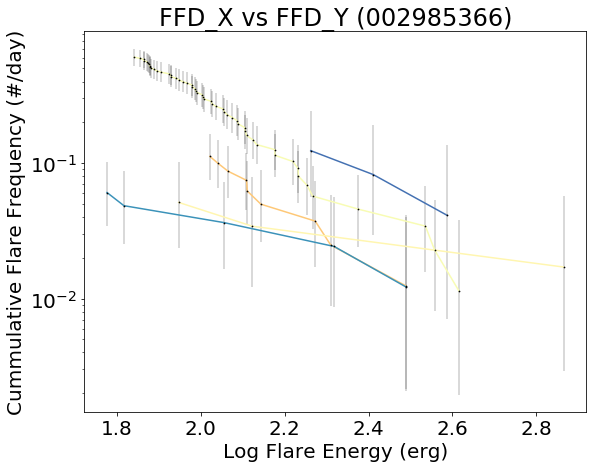

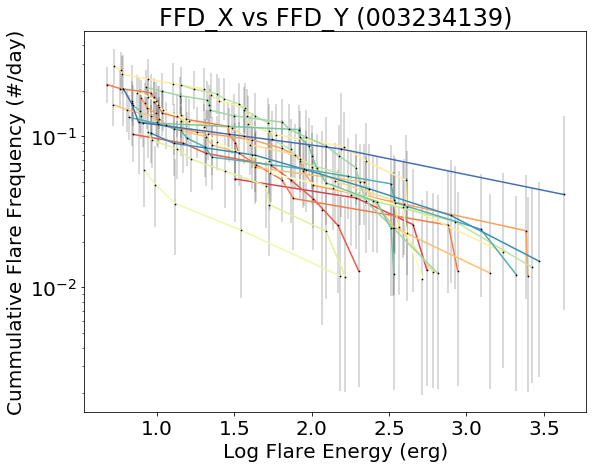

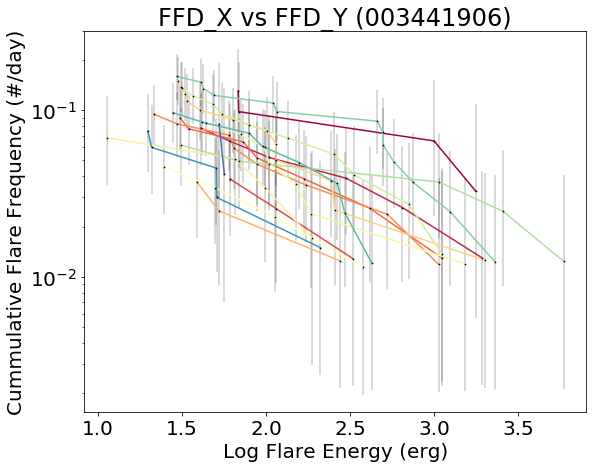

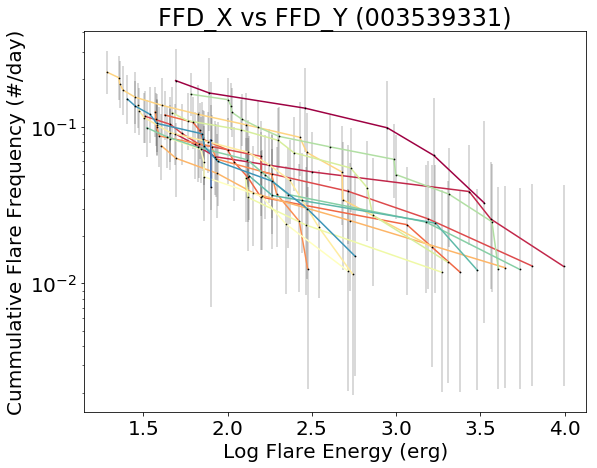

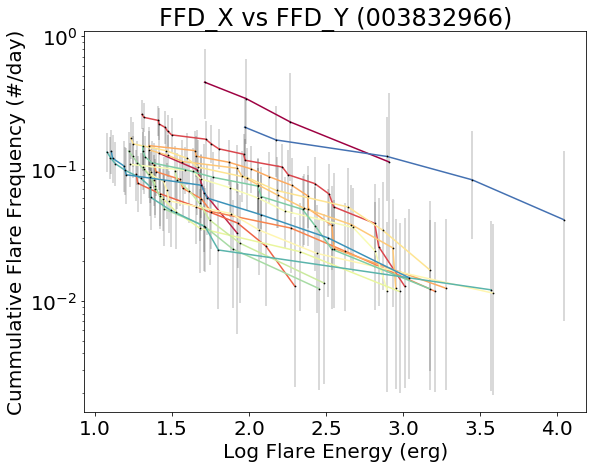

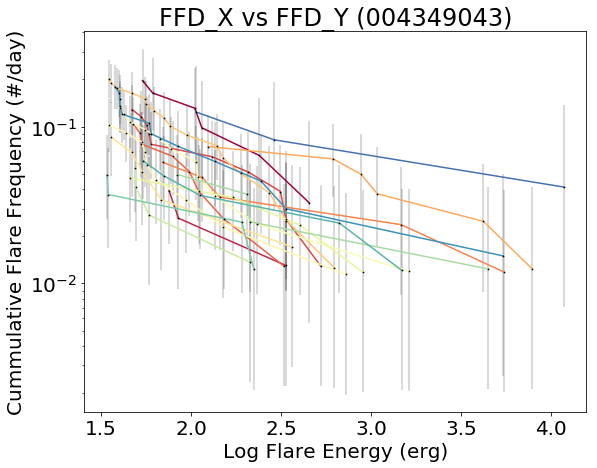

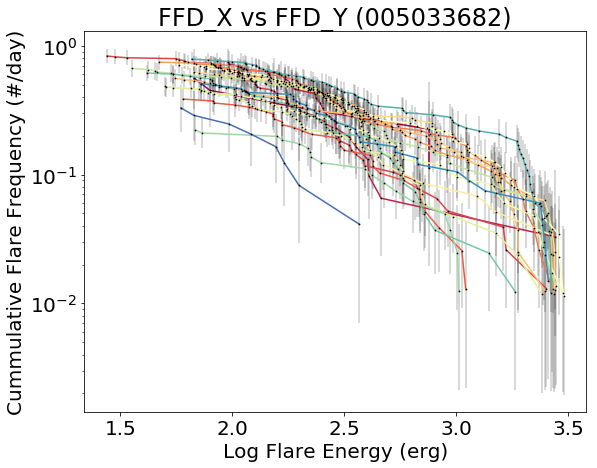

In [23]:
#plotting a reverse cummulative sum for a single KIC# number (using ED68i cutoff), hoping for a smooth change in frequency over time

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log')
    energyList = []
    frequencyList = []
    
    for x in range(len(files)):
        
    
        #getting the total duration of each file
        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 

                
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array

        
        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
    
        plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68

        
        err_dn =  []
        err_up = []
        
        for y in range (len(ffd_yFrequency[ok68])): #calculating the error bars for each point

            toteFlare = toteDur*ffd_yFrequency[ok68][y]
            err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
            err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)
           
        plt.errorbar(ffd_xEnergy[ok68], ffd_yFrequency[ok68], yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .75)

        
    
    #plt.savefig('ffd_x-vs-ffd_y-sig-plot/'+KIC+'_sig_FFD.png')



In [ ]:
##to be used from terminal
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

#a bunch of checks, looking for correct input
if(len(sys.argv) == 1 or (sys.argv[1] == "help")):
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'evf'             for an energy vs frequency plot")
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'evfs'            for an energy vs frequency plot, plotting only the data above the ED68i cutoff")
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'tvf' 'energy#'   for a time vs frequency plot, fixed at the specified log-energy value")
    sys.exit()

try:
    file = sys.argv[1]
    targets = open(file, "r") # a file containing all the KICs we want to plot
except:
    print("Error: Cannot open "+file+". Type 'help' for a list of possible commands")
    sys.exit()

if((len(sys.argv) == 2) or (not((sys.argv[2] == "evfs") or (sys.argv[2] == "evf") or (sys.argv[2] == "tvf")))):
    print("Error: Unrecognized command. Type 'help' for a list of possible commands.")
    sys.exit()

    

np.seterr(invalid='ignore') #ignore the Nans
plt.rcParams.update({'font.size': 20}) #font size
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1",
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model",
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")
EPOINT = 0


###################################################################################################################################
#plotting energy vs frequency
###################################################################################################################################
def plotEVF():

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("FFD_X vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Log Flare Energy (erg)")
        plt.yscale('log')

        for x in range(len(files)):

            #getting the total duration of each file
            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 

            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array

            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68
            plt.plot(ffd_xEnergy, ffd_yFrequency, lw = 0.3, c = cmap(x/float(len(files)))) #plotting all data


            #plotting the error bars. Must use the total flare #, rather than frequency, to calc the error.
            err_dn =  []
            err_up = []

            for y in range (len(ffd_yFrequency)):

                toteFlare = toteDur*ffd_yFrequency[y]
                err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
                err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)

            plt.errorbar(ffd_xEnergy, ffd_yFrequency, yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .55)

        plt.savefig('ffd_x-vs-ffd_y-whole-plot/'+KIC+'_whole_FFD.png')
        
    plt.show()

###################################################################################################################################
#plotting energy vs frequency but only for significant data, data above the ED68i cutoff
###################################################################################################################################
def plotEVFsig():

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("FFD_X vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Log Flare Energy (erg)")
        plt.yscale('log')
        energyList = []
        frequencyList = []

        for x in range(len(files)):


            #getting the total duration of each file
            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 


            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array


            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68


            err_dn =  []
            err_up = []

            for y in range (len(ffd_yFrequency[ok68])): #calculating the error bars for each point

                toteFlare = toteDur*ffd_yFrequency[ok68][y]
                err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
                err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)

            plt.errorbar(ffd_xEnergy[ok68], ffd_yFrequency[ok68], yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .75)
     
        plt.savefig('ffd_x-vs-ffd_y-sig-plot/'+KIC+'_sig_FFD.png')

    plt.show()

    
###################################################################################################################################
#Specify a fixed log-energy value. Plot the mean-time vs FFD_y values = plot time vs flare rate per day
###################################################################################################################################
def plotTVF(logEnergyConstant): 

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("Time vs FFD_Y (KIC "+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Mean T_Start (days)")
        plt.yscale('log')
        plt.ylim([0.001,10])
        plt.xlim([0,1800])
        time = []
        frequency = []
        err_list = []
        chisqSum = 0

        for x in range(len(files)):

            #getting the total duration of each file
            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 


            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array


            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day


            if(np.amax(ffd_xEnergy) >= logEnergyConstant >= np.amin(ffd_xEnergy)): #checking that the energy constant isn't out of bound,
                                                                                   #otherwise, interpolate doesn't work

                ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

                meanstart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file


                if any(ok68): #checking if ok68 contains at least one 'true'


                    ffd_yForMeanstart = np.interp(logEnergyConstant, ffd_xEnergy[ok68][::-1], ffd_yFrequency[ok68][::-1])#interpolating the ffd_y

                    time.append(meanstart) #making lists so we can fit a line later
                    frequency.append(ffd_yForMeanstart)


                    toteFlare = ffd_yForMeanstart * toteDur #calculating error bars: multiplying the frequency by total duration to get total flare #   


                    err_dn = (np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur
                    err_up = (np.sqrt(toteFlare + 0.75) + 1.0)/toteDur
                    err_list.append(err_up) #collecting errors, to be used in chi-square calc


                    plt.errorbar(meanstart, ffd_yForMeanstart, yerr = [[err_dn], [err_up]], fmt='ro',markersize=6, elinewidth=1,capsize=6)#plotting error


        #return the parameters (slope and intercept) and the covariance matrix. Plot a line with those parameters                        
        params, cov = np.polyfit(time, frequency, 1, cov=True, full =False)
        slope, intercept = params
        line_y = [slope * i + intercept for i in time]
        plt.plot(time, line_y, 'black',  lw=3,) #plotting a best fit line


        #chi-square calculation
        for y in range(len(frequency)):
            chisqSum += ((frequency[y] - line_y[y]) / err_list[y])**2.0 
        chisq = chisqSum / np.size(frequency)


        #adding vales to graph, using the convariance matrix to get error in the slope
        plt.text(50, 6,'Slope = {:0.2e} +/- {:0.2e}'.format(slope,np.sqrt(cov[0][0])))
        plt.text(50, 3.5,'Slope/Uncertainty = {:0.2f}'.format(np.abs(slope/np.sqrt(cov[0][0]))))
        plt.text(50, 2,'Chi-Square = {:0.2f}'.format(chisq))

        #plt.savefig('time-vs-ffd_y-plot/'+KIC+'_vs_time(E=' + str(logEnergyConstant) + ').png')
        
    plt.show()
    
###################################################################################################################################
###################################################################################################################################

if(sys.argv[2] == "evf"): #plotting energy vs frequency
    plotEVF()

elif(sys.argv[2] == "evfs"): #plotting significant energy vs frequency
    plotEVFsig()

elif(sys.argv[2] == "tvf"): #plotting time vs frequency
    try:
        logEnergyConstant = float(sys.argv[3]) + EPOINT # the fixed energy value
    except:
        print("Error: Cannot convert fixed-energy value to a float OR no fixed-energy value was provided . Type 'help' for a list of possible commands.")
        sys.exit()
    plotTVF(logEnergyConstant)
